In [1]:
using Turing, Plots, Random, DelimitedFiles, DataFrames

In [2]:
Random.seed!(0);
#Generate data
T = 120

w1, w2, w3 = 0.1, 0.25, 1

x_data = [randn()]
y_data = [x_data[end]+0.1*randn()]
for t=2:25
    append!(x_data, x_data[end] + sqrt(1/w1)*randn())
    append!(y_data, x_data[end] + randn())
end
for t=26:75
    append!(x_data, x_data[end] + sqrt(1/w2)*randn())
    append!(y_data, x_data[end] + randn())
end
for t=76:T
    append!(x_data, x_data[end] + sqrt(1/w3)*randn())
    append!(y_data, x_data[end] + randn())
end

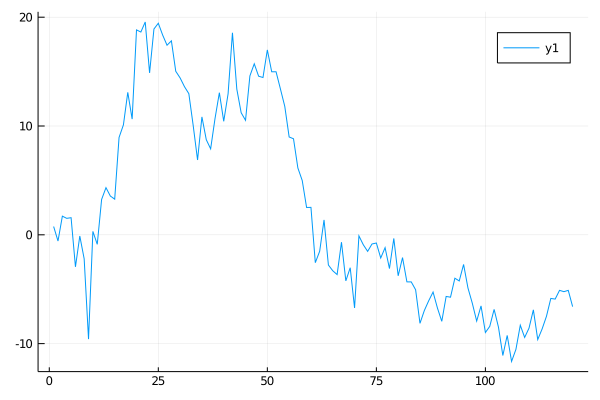

In [3]:
plot(y_data)

In [4]:
@model function SSSM(y)
    vars = [10, 4, 1]
    T = length(y)
    z = tzeros(Int,T-1)
    x = Vector(undef, T)
    M = Vector{Vector}(undef,3) # Transition matrix
    M[1] ~ Dirichlet([100,1,1])
    M[2] ~ Dirichlet([1,100,1])
    M[3] ~ Dirichlet([1,1,100])
    
    z[1] ~ Categorical(3)
    x[1] ~ Normal()
    y[1] ~ Normal(x[1],sqrt(1))
    for t = 2:T-1
        x[t] ~ Normal(x[t-1],sqrt(vars[z[t-1]]))
        y[t] ~ Normal(x[t],sqrt(1))
        z[t] ~ Categorical(vec(M[z[t-1]]))
    end
    x[T] ~ Normal(x[T-1],sqrt(vars[z[T-1]]))
    y[T] ~ Normal(x[T],sqrt(1))
end

SSSM (generic function with 1 method)

In [5]:
gibbs = Gibbs(NUTS(1000,0.65,:x,:M),PG(50,:z))
tt = @elapsed chain = sample(SSSM(y_data),gibbs,100)

┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference /home/polyten/.julia/packages/Turing/a9ANC/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:09


91.165451097

In [6]:
mean(group(chain,:M).value.data, dims=1)

LoadError: UndefVarError: chain not defined

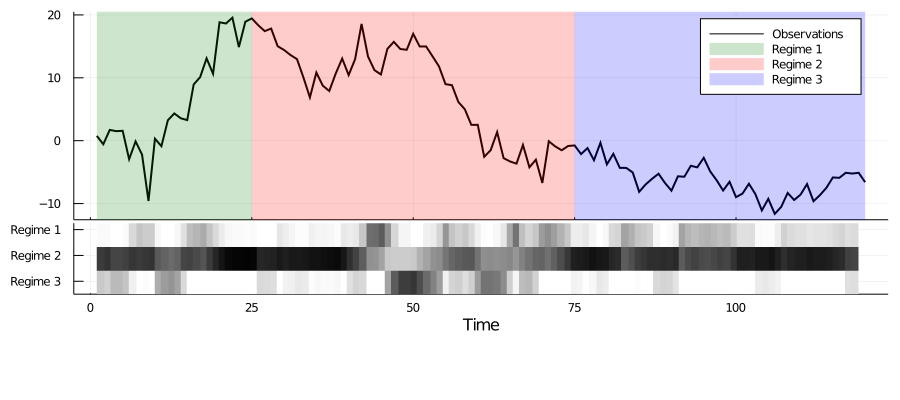

In [7]:
m_z = zeros(3,T-1)
for t=1:T-1
    dd = [(i, count(==(i), group(chain,:z).value.data[:,t])) for i in [1.0,2.0,3.0]]
    num1, num2, num3 = dd[1][2], dd[2][2], dd[3][2]
    num = num1+num2+num3
    m_z[1,t] = num1/num
    m_z[2,t] = num2/num
    m_z[3,t] = num3/num
end

estimate = zeros(12,T-1)
for i=1:4
    estimate[i,:] = 1. .- m_z[1,:]
    estimate[i+4,:] = 1. .- m_z[2,:]
    estimate[i+8,:] = 1. .- m_z[3,:]
end

gr()
l = @layout [a ; b]
mm=Plots.PlotMeasures.mm
p1 = plot(1:T, y_data, w=2, labels = "Observations", legend=(:best), color=:black)
vspan!(p1,[1,25], color = :green, alpha = 0.2, labels = "Regime 1");
vspan!(p1,[25,75], color = :red, alpha = 0.2, labels = "Regime 2");
vspan!(p1,[75,T], color = :blue, alpha = 0.2, labels = "Regime 3");

p2 = plot(Gray.(estimate), link=:x, xlabel="Time", top_margin=-25.0mm)
yticks!([2:4:10;], ["Regime 1", "Regime 2", "Regime 3"])

p = plot(p1, p2, layout = l, size = (900, 400))

In [8]:
writedlm("NUTSestimates.txt", estimate)